In [1]:
# import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, f1_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from scipy import stats
from sklearn.model_selection import KFold, cross_val_predict, cross_val_score, GridSearchCV
from google.colab import files


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
# data prepartion
import os
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
file_path = 'exchangedata.csv' # link to exchange data

In [4]:
data = pd.read_csv(file_path)
data.head()

,domain,trust_score,blacklisted,ip_bad_count_bad,ssl_valid,ip_country,anonymous_whois,dnsblock_threat_count,whois_registration_duration,whois_valid_email,avg_review_score,facebook_comments_negative_count,facebook_comments_positive_count,scamadviser_votes_legit,scamadviser_votes_scam,scamadviser_votes_fake,is_legit
0,merlinswap.org,56.0,0,0.29,1,US,1,0,0.53,0,0.00,0.0,0.0,0,0,0,1
1,fatbtc.com,1.0,0,0.03,1,US,1,0,10.51,0,1.49,0.0,0.0,0,0,0,1
2,camelot.exchange,12.0,0,0.26,1,US,1,0,1.82,0,0.00,0.0,0.0,0,0,0,1
3,fast.exchange.onetrading.com,80.0,0,0.00,1,US,1,0,20.05,1,0.00,0.0,0.0,0,0,0,1
4,dackieswap.xyz,1.0,0,0.41,1,US,1,0,1.28,0,1.00,0.0,0.0,0,0,0,1


In [5]:
print(data.info())
print(data.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1084 entries, 0 to 1083
Data columns (total 17 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   domain                            1064 non-null   object 
 1   trust_score                       1084 non-null   float64
 2   blacklisted                       1084 non-null   int64  
 3   ip_bad_count_bad                  1084 non-null   float64
 4   ssl_valid                         1084 non-null   int64  
 5   ip_country                        1084 non-null   object 
 6   anonymous_whois                   1084 non-null   int64  
 7   dnsblock_threat_count             1084 non-null   int64  
 8   whois_registration_duration       1084 non-null   float64
 9   whois_valid_email                 1084 non-null   int64  
 10  avg_review_score                  1084 non-null   float64
 11  facebook_comments_negative_count  1084 non-null   float64
 12  facebo

In [6]:

# drop domain name - not needed
data.drop('domain', axis=1, inplace=True)


# Convert boolean columns to int
data['anonymous_whois'] = data['anonymous_whois'].astype(int)
data['ssl_valid'] = data['ssl_valid'].astype(int)
data['whois_valid_email'] = data['whois_valid_email'].astype(int)
data['blacklisted'] = data['blacklisted'].astype(int)
data['is_legit'] = data['is_legit'].astype(int)

In [7]:
#  encoding categorical features

# count the number of unique countries in the ip_country column
unique_countries = data['ip_country'].nunique()
print(f"Number of unique countries: {unique_countries}")

#
one_hot = pd.get_dummies(data['ip_country'])

# Concatenate the one-hot encoded columns back to the original DataFrame
data = pd.concat([data, one_hot], axis=1)

# drop ip country
data = data.drop('ip_country', axis=1)

data.head(10)

Number of unique countries: 27


,trust_score,blacklisted,ip_bad_count_bad,ssl_valid,anonymous_whois,dnsblock_threat_count,whois_registration_duration,whois_valid_email,avg_review_score,facebook_comments_negative_count,...,KR,LT,MY,NL,PT,RU,SG,SK,US,USA
0,56.0,0,0.29,1,1,0,0.53,0,0.00,0.0,...,False,False,False,False,False,False,False,False,True,False
1,1.0,0,0.03,1,1,0,10.51,0,1.49,0.0,...,False,False,False,False,False,False,False,False,True,False
2,12.0,0,0.26,1,1,0,1.82,0,0.00,0.0,...,False,False,False,False,False,False,False,False,True,False
3,80.0,0,0.00,1,1,0,20.05,1,0.00,0.0,...,False,False,False,False,False,False,False,False,True,False
4,1.0,0,0.41,1,1,0,1.28,0,1.00,0.0,...,False,False,False,False,False,False,False,False,True,False
5,1.0,0,0.00,1,1,0,11.24,1,1.78,0.0,...,False,False,False,False,False,False,False,False,True,False
6,1.0,0,0.03,1,0,0,6.13,0,2.25,0.0,...,False,False,False,False,False,False,False,False,True,False
7,100.0,0,0.29,1,1,0,15.34,0,2.25,0.0,...,False,False,False,False,False,False,False,False,True,False
8,41.0,0,0.16,1,1,0,2.95,0,0.50,0.0,...,False,False,False,False,False,False,False,False,True,False
9,1.0,0,0.10,1,1,0,8.41,0,1.79,0.0,...,False,False,False,True,False,False,False,False,False,False


In [8]:
# model training
# Splitting the dataset into training and testing sets

X = data.drop('is_legit', axis=1)  # Features
y = data['is_legit']  # Target variable



In [9]:
# Standardize the features
scaler = StandardScaler()

# Fit the scaler to the numerical columns in the data
numerical_columns = ['trust_score', 'ip_bad_count_bad', 'dnsblock_threat_count', 'whois_registration_duration', 'avg_review_score',
             'facebook_comments_negative_count', 'facebook_comments_positive_count', 'scamadviser_votes_legit', 'scamadviser_votes_scam',
             'scamadviser_votes_fake']
data[numerical_columns] = scaler.fit_transform(data[numerical_columns])

# Print the scaled data
data.head()

data['is_legit']

0       1
1       1
2       1
3       1
4       1
       ..
1079    1
1080    0
1081    1
1082    0
1083    0
Name: is_legit, Length: 1084, dtype: int64

In [10]:
# Splitting into features (X) and target (y)
X = data.drop('is_legit', axis=1)
y = data['is_legit']

In [13]:
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
# Initialize the MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)

# Define the parameter grid
params = {
    'hidden_layer_sizes': [(50,), (100,), (150,)],  # Number of neurons in each hidden layer
    'activation': ['relu', 'tanh'],  # Activation functions
    'solver': ['adam', 'sgd'],  # Solvers for weight optimization
    'alpha': [0.0001, 0.001, 0.01],  # L2 penalty (regularization term) parameter
    'learning_rate': ['constant', 'invscaling', 'adaptive'],  # Learning rate schedule for weight updates
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=mlp, param_grid=params, cv=10, scoring='accuracy', n_jobs=-1)

In [14]:
from sklearn.base import clone

# Performing grid search
grid_search.fit(X, y)



/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


GridSearchCV(cv=10, estimator=MLPClassifier(max_iter=300, random_state=42),
             n_jobs=-1,
             param_grid={'activation': ['relu', 'tanh'],
                         'alpha': [0.0001, 0.001, 0.01],
                         'hidden_layer_sizes': [(50,), (100,), (150,)],
                         'learning_rate': ['constant', 'invscaling',
                                           'adaptive'],
                         'solver': ['adam', 'sgd']},
             scoring='accuracy')

In [15]:
# Retrieving best model
best_model = grid_search.best_estimator_
best_model_clone = clone(best_model)

# Retrieving best params
best_params = grid_search.best_params_
print(best_params)

{'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (150,), 'learning_rate': 'constant', 'solver': 'adam'}


In [16]:
# define 10-fold cross-validation
kf = KFold(n_splits=10, shuffle=True)

In [17]:

# Evaluating model perfomance using k-fold cross validation to test the performance
y_pred_all = cross_val_predict(best_model, X, y, cv=kf, method='predict')
y_pred_proba_all = cross_val_predict(best_model, X, y, cv=kf, method='predict_proba')[:, 1]


accuracy_scores = cross_val_score(best_model, X, y, cv=kf, scoring='accuracy')
precision_scores = cross_val_score(best_model, X, y, cv=kf, scoring='precision')
recall_scores = cross_val_score(best_model, X, y, cv=kf, scoring='recall')
f1_scores = cross_val_score(best_model, X, y, cv=kf, scoring='f1')


# Print average metrics
print("Avg accuracy: ", np.mean(accuracy_scores), "s.d: ", np.std(accuracy_scores))
print("Avg precision: ", np.mean(precision_scores), "s.d: ", np.std(precision_scores))
print("Avg recall: ", np.mean(recall_scores), "s.d: ", np.std(recall_scores))
print("Avg f1: ", np.mean(f1_scores), "s.d: ", np.std(f1_scores))

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

Avg accuracy:  0.9243119266055044 s.d:  0.02891682567106535
Avg precision:  0.9127254659954372 s.d:  0.0358778410401541
Avg recall:  0.9089767360173914 s.d:  0.03166554760147873
Avg f1:  0.9183240967419419 s.d:  0.04225174675341247


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


In [18]:
# experiment with selected features

# Prepare data with important features only
# X_important = X[important_features]

selected_features = ['whois_registration_duration',
                     'trust_score',
                     'avg_review_score',
                     'ip_bad_count_bad',
                      'scamadviser_votes_scam',
                      'ssl_valid',
                     'whois_valid_email',
                     'scamadviser_votes_legit',
                      'facebook_comments_negative_count',
                      'anonymous_whois',
                      'dnsblock_threat_count',
                     'scamadviser_votes_fake' ]

# Filter the DataFrame to include only the selected features
X_important = X[selected_features]

# Evaluate model with important features using cross-validation
y_pred_important = cross_val_predict(best_model_clone, X_important, y, cv=kf, method='predict')
y_pred_proba_important = cross_val_predict(best_model_clone, X_important, y, cv=kf, method='predict_proba')[:, 1]

accuracy_scores_important = cross_val_score(best_model_clone, X_important, y, cv=kf, scoring='accuracy')
precision_scores_important = cross_val_score(best_model_clone, X_important, y, cv=kf, scoring='precision')
recall_scores_important = cross_val_score(best_model_clone, X_important, y, cv=kf, scoring='recall')
f1_scores_important = cross_val_score(best_model_clone, X_important, y, cv=kf, scoring='f1')


# Print average metrics
print("Avg accuracy: ", np.mean(accuracy_scores), "s.d: ", np.std(accuracy_scores))
print("Avg precision: ", np.mean(precision_scores), "s.d: ", np.std(precision_scores))
print("Avg recall: ", np.mean(recall_scores), "s.d: ", np.std(recall_scores))
print("Avg f1: ", np.mean(f1_scores), "s.d: ", np.std(f1_scores))


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

Avg accuracy:  0.9243119266055044 s.d:  0.02891682567106535
Avg precision:  0.9127254659954372 s.d:  0.0358778410401541
Avg recall:  0.9089767360173914 s.d:  0.03166554760147873
Avg f1:  0.9183240967419419 s.d:  0.04225174675341247


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


In [19]:
# Perform paired t-tests for all metrics
from scipy import stats

metrics = ['accuracy', 'precision', 'recall', 'f1']
scores_all_features = [accuracy_scores, precision_scores, recall_scores, f1_scores]
scores_selected_features = [accuracy_scores_important, precision_scores_important, recall_scores_important, f1_scores_important]

for metric, scores_all, scores_selected in zip(metrics, scores_all_features, scores_selected_features):
    t_stat, p_value = stats.ttest_rel(scores_all, scores_selected)
    print(f'\nPaired t-test for {metric}:')
    print(f'T-statistic: {t_stat:.4f}')
    print(f'P-value: {p_value:.4f}')
    if p_value < 0.05:
        print(f"The difference in {metric} between the models with all features and selected features is statistically significant.")
    else:
        print(f"The difference in {metric} between the models with all features and selected features is not statistically significant.")



Paired t-test for accuracy:
T-statistic: 1.2654
P-value: 0.2375
The difference in accuracy between the models with all features and selected features is not statistically significant.

Paired t-test for precision:
T-statistic: 1.0313
P-value: 0.3293
The difference in precision between the models with all features and selected features is not statistically significant.

Paired t-test for recall:
T-statistic: 1.2432
P-value: 0.2452
The difference in recall between the models with all features and selected features is not statistically significant.

Paired t-test for f1:
T-statistic: 2.6507
P-value: 0.0264
The difference in f1 between the models with all features and selected features is statistically significant.


In [20]:
# Compare the results
print(f"Improvement in accuracy: {accuracy_scores_important.mean() - accuracy_scores.mean():.4f}")
print(f"Improvement in precision: {precision_scores_important.mean() - precision_scores.mean():.4f}")
print(f"Improvement in recall: {recall_scores_important.mean() - recall_scores.mean():.4f}")
print(f"Improvement in F1-score: {f1_scores_important.mean() - f1_scores.mean():.4f}")

Improvement in accuracy: -0.0212
Improvement in precision: -0.0201
Improvement in recall: -0.0287
Improvement in F1-score: -0.0286


In [21]:
# roc function
import matplotlib.pyplot as plt

def plot_roc_curve(y_true, y_scores, title):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.show()

    data_filename = title+'.csv'
    # Save the ROC curve data
    roc_data = pd.DataFrame({'fpr': fpr, 'tpr': tpr})
    roc_data.to_csv(data_filename, index=False)

    # Download the files to local machine
    files.download(data_filename)


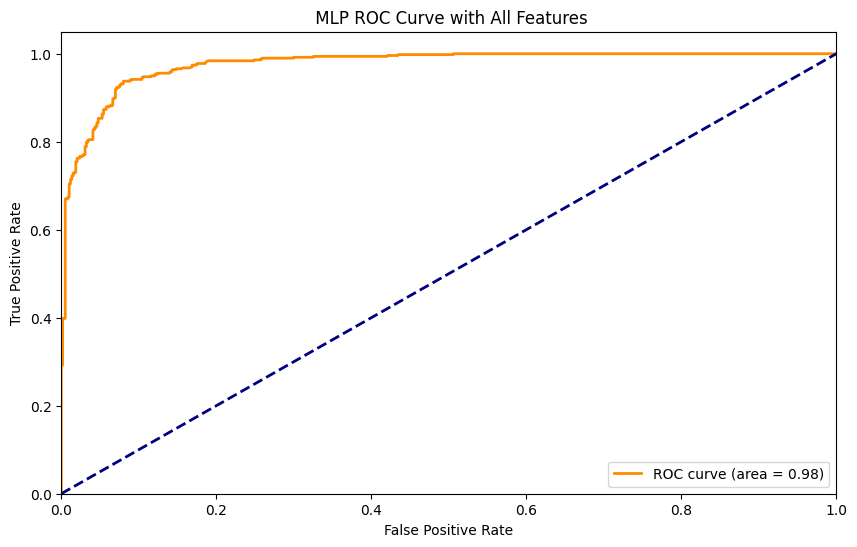

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

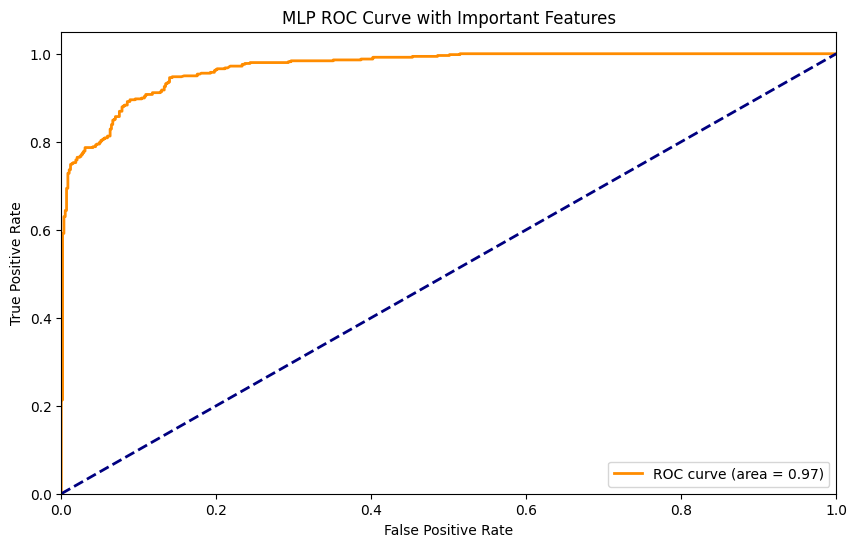

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [22]:
# ROC curve for all features
plot_roc_curve(y, y_pred_proba_all, ' MLP ROC Curve with All Features')

# ROC curve for important features
plot_roc_curve(y, y_pred_proba_important, 'MLP ROC Curve with Important Features')